In [96]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 13a

## Model with
1. Early stopping
2. ADAM
3. Mini Batch
4. L2 Regularization
5. Swish activation


In [97]:
# Lets import some libraries
import os

import sys

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from time import time

import pickle

from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler

from scipy.misc import derivative

import warnings
warnings.filterwarnings('ignore')

In [98]:
# Some basic parameters

inpDir = 'input' # location where input data is stored
outDir = 'output' # location to store outputs
modelDir = 'models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 4001 # number of epochs
ALPHA = 0.1 # learning rate


SAVE_MODEL = False

MIN_LOSS = sys.float_info.max -1 # to save model

LAMBDA = 0.001 # regularization lambda

PATIENCE = 500 # patience level for epochs

BATCH_SIZE = 256 # We want even last batch to be 256

TRAIN_SIZE = int(BATCH_SIZE*64) # to create 64 batches of 256 rows each

modelFilePath = os.path.join(modelDir,subDir, 'S13_fifa_1L_model_swish_adam_earlystopping_minibatch.pkl')
lossFilePath = os.path.join(modelDir, subDir, 'S13_fifa_1L_model_swish_adam_earlystopping_minibatch.csv')

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Read FIFA 2019 data set

In [99]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [100]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [101]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [102]:
# Are there NaNs Still?

data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [103]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [104]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [105]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [106]:
y = data_df["Position"].values

X = data_df.drop("Position", axis = 1)

In [107]:
# one hot encoding
y = pd.get_dummies(y).values
y

array([[False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True],
       ...,
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False,  True, False]])

In [108]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=TRAIN_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(16384, 33) (16384, 4) (1763, 33) (1763, 4)


In [109]:
print (X_test.shape[0] / X_train.shape[0] )

0.10760498046875


In [110]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

## Prepare model

### Activation and Softmax
<p style="font-family: Arial; font-size:1.2em;color:black;">
Softmax code is for demo purpose only. In general softmax functions can be highly unstable.<br>
    <b>Note:</b> If you must implement softmax, use libraries such as scipy.special.softmax.<br><br>
Taking instability of Softmax into account, it is recommended to tweak the formula a bit:<br><br>
<p>
    
$\mathrm{softmax}(z_i) = \large{\frac{e^{z_i – max\left ( z \right )}}{\sum\limits_{i=1}^{L} e^{z_i- max\left ( z \right )}}}$

In [111]:
def fn_softmax(z):
    
    '''
    Args:
        z : a matrix of z values of shape (m, n_output)
    returns:
        Softmax values of z
    
    '''
    
    exp_scores = np.exp(z - np.amax(z, axis = 1, keepdims = True))

    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [112]:
def fn_actv(z):
    '''
    Args:
        z: array z value
    Returns:
        a: array - activations
    '''
    
    return z  / (1 + np.exp(-z))

def fn_actv_prime(z):
    '''
    Args:
        z: array
    Returns:
        a: array - activation prime
    '''
    
    #return (np.exp(-z) * (z + 1) +1 )/ (1 + np.exp(-z))**2
    return derivative(fn_actv, z, dx=1e-6)

## Adam Optimizer

In [113]:
def adam_optimizer(dW, m_t, v_t, t):
    
    '''
    Adam optimizer function. Note loop is in the main code.
    Args: 
        dW: gradient of weights/bias to be optimised
        m_t : 1st Moment vector of shape same as weights/bias
        v_t : 2nd moment vector of shape same as weights/bias
        t : time step
    Returns:
        updated dW
    '''
    
    t = t + 1 # first epoch t = 0 => for t = 0 both m_cap and v_cap will be infinite
    
    m_t = beta_1 * m_t + ( 1 - beta_1 ) * dW           # the moving averages of the gradient
    
    v_t = beta_2 * v_t + ( 1 - beta_2 ) * ( dW * dW )  # the moving averages of the squared gradient
    
    m_cap = m_t/(1-(beta_1)**t)                        # the bias-corrected first moment estimate

    v_cap = v_t/(1-(beta_2)**t)                        # the bias-corrected second moment estimates
    
    return (alpha * m_cap ) / ( np.sqrt ( v_cap ) + adam_epsilon ) # update dW

In [114]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model, X_l, y_l):
    '''
    Args:
        model: dictionay object containing weights and biases
        X_l: Feature Matrix
        y_l: Labels matrix (One-hot encoding expected)
    Returns:
        Average loss
    '''
    
    # Extract Weights and biases from the model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    m = X_l.shape[0] # number of samples in X
    
    # Layer 1
    z1 = X_l.dot(W1) + b1  # Aggregation
    a1 = fn_actv(z1)       # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2   # Aggregation
    a2 = fn_softmax(z2)    # Activation
    
    # Calculating the loss
    data_loss = -(y_l * np.log(a2) + (1 - y_l) * np.log(1 - a2) ).sum() 
    
    ################################
    ### Add regularization terms ###
    ################################

    data_loss += reg_lambda/2 * (np.sum(W1**2) + 
                                 np.sum(W2**2))
    
    
    return 1./m * data_loss

In [115]:
# Helper function to predict an output

def predict(model, X_p):
    '''
     Args:
         model: dict object containing weights and biases
         X_p: Feature Matrix
    Returns:
        Predictions against the instances
         
    '''
    # Extract Weights and biases from the model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']  
    
    # Layer 1
    z1 = X_p.dot(W1) + b1  # Aggregation
    a1 = fn_actv(z1)       # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2   # Aggregation
    a2 = fn_softmax(z2)    # Activation
   
    return np.argmax(a2, axis = 1)

In [116]:
# Prepare the Model

def build_model(nn_hdim, 
                X : np.ndarray, y : np.ndarray,
                X_t: np.ndarray, y_t: np.ndarray,
                batch_size = 128,
                epochs = 20000, 
                print_loss=False):
    
    '''
    Args:
        nn_hdim    : number of nodes in hidden layer
        X          : Features to train
        y          : Trainig targets (labels)
        X_t        : Features to test
        y_t        : Testing targets (labels)
        batch_size : size of the minibatch
        alpha      : learning rate
        epochs     : Number of passes through the training data for gradient descent
        print_loss : If True, print the loss every nnn iterations
        
    Returns:
        Model      : Dictionary object containing weights and biases
    '''
    if os.path.isfile(modelFilePath):
        # print (f'Pre-trained model found at {modelFilePath}. Loading....')
        
        with open(modelFilePath, 'rb') as file:
            model_details = pickle.load(file)
            model = model_details['weights']
        print (f'Loaded existing model with\n {model_details["description"]}\n\n')
        print ('#'*50)
        W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
        m_t_w1, v_t_w1 = model['m_t_w1'], model['v_t_w1']
        m_t_b1, v_t_b1 = model['m_t_b1'], model['v_t_b1']
        m_t_w2, v_t_w2 = model['m_t_w2'], model['v_t_w2']
        m_t_b2, v_t_b2 = model['m_t_b2'], model['v_t_b2']
        
    else:
        # print (f'No model found at {modelFilePath}. Initializing....')

        W1 = np.random.rand(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim) # as per Lacun Normal
        m_t_w1 = np.zeros_like(W1)  # first Moment Matrix for weights
        v_t_w1 = np.zeros_like(W1)  # second Moment Matrix for weights
        
        
        b1 = np.zeros((1, nn_hdim))
        m_t_b1 = np.zeros_like(b1) # first Moment Matrix for bias
        v_t_b1 = np.zeros_like(b1) # second Moment Matrix for bias
        
        W2 = np.random.rand(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
        m_t_w2 = np.zeros_like(W2)  # first Moment Matrix for weights
        v_t_w2 = np.zeros_like(W2)  # second Moment Matrix for weights

        
        b2 = np.zeros((1, nn_output_dim))
        m_t_b2 = np.zeros_like(b2) # first Moment Matrix for bias
        v_t_b2 = np.zeros_like(b2) # second Moment Matrix for bias
    
        model ={}
    
    startTime = time()
    
    curr_loss = 0
    ct_loss = 0.
    epoch, loss, t_loss, acc, t_acc = [], [], [], [], []
    
    
    #### Changes in this notebook
    since_last_save = 0
    min_loss = MIN_LOSS
    num_batches =  int(X.shape[0] / batch_size)
    
    for i in range(0, epochs):
        
        epochTime = time()
        
        for batch in range (num_batches):
            
            batch_start = batch * batch_size
            batch_end   = (batch +1) * batch_size
            
            if batch_end >= X.shape[0]:
                batch_end  = X.shape[0] - 1
                
            a0 = X[batch_start : batch_end, : ]
            y0 = y[batch_start : batch_end]
                
            num_examples = a0.shape[0] # training set size
        
            #### Forward ------------------------------
            # Layer 1
            z1 = a0.dot(W1) + b1 
            a1 = fn_actv(z1)    # activation

            # Layer 2
            z2 = a1.dot(W2) + b2 
            a2 = fn_softmax(z2)    # activation


            ### Back Prop ------------------------------
            #Layer 2
            dz2 = a2- y0

            dW2 = (a1.T).dot(dz2)  
            assert(W2.shape == dW2.shape), 'Shape of W2 {} and dW2 {} do not match'.format(W2.shape, dW2.shape)

            db2 = np.sum(dz2, axis=0, keepdims=True)
            assert(b2.shape == db2.shape), 'Shape of b2 {} and db2 {} do not match'.format(b2.shape, db2.shape)

            da1= dz2.dot(W2.T)

            #Layer 1
            dz1 = da1 * fn_actv_prime(a1)
            dW1 = (a0.T).dot(dz1)
            assert(W1.shape == dW1.shape), 'Shape of W1 {} and dW1 {} do not match'.format(W1.shape, dW1.shape)

            db1 = np.sum(dz1, axis=0, keepdims=True)
            assert(b1.shape == db1.shape), 'Shape of b1 {} and db1 {} do not match'.format(b1.shape, db1.shape)
            
            ######################
            ### L2 Regularizer ###
            ######################
            # b1 and b2 don't have regularization terms
            dW2 += reg_lambda * W2
            dW1 += reg_lambda * W1
            
            t = i*batch_size + batch
 
            # ADAM Optimizer
            W1 += -adam_optimizer(dW1, m_t_w1, v_t_w1, t) / num_examples
            W2 += -adam_optimizer(dW2, m_t_w2, v_t_w2, t) / num_examples

            b1 += -adam_optimizer(db1, m_t_b1, v_t_b1, t) / num_examples
            b2 += -adam_optimizer(db2, m_t_b2, v_t_b2, t) / num_examples
        
        
            model = {'W1': W1, 'm_t_w1': m_t_w1, 'v_t_w1': v_t_w1,
                     'b1': b1, 'm_t_b1': m_t_b1, 'v_t_b1': v_t_b1,
                     'W2': W2, 'm_t_w2': m_t_w2, 'v_t_w2': v_t_w2,
                     'b2': b2, 'm_t_b2': m_t_b2, 'v_t_b2': v_t_b2}
        
        
        
        if i % 10 == 0:
            
            # Keep count of epoch
            epoch.append(i)
            
            # Calculate loss
            curr_loss = calculate_loss (model, X, y)
            loss.append(curr_loss)
            
            ct_loss = calculate_loss ( model, X_t, y_t)
            t_loss.append(ct_loss)
            
            # Calculate accuracy
            y_pred = predict(model, X)
            curr_acc = accuracy_score(np.argmax(y, axis = 1), y_pred )
            acc.append(curr_acc)
            
            yt_pred = predict(model, X_t)
            currt_acc = accuracy_score(np.argmax(y_t, axis = 1), yt_pred )
            t_acc.append(currt_acc)
            
            #####################################
            ### Save model with min test loss ###
            #####################################
            if ct_loss < min_loss:
                min_loss = ct_loss
                model_save = model.copy()
                save_epoch = i
                since_last_save = 0  # reset counter once model is saved 

        if since_last_save > PATIENCE:
            # print ('Saving model at epoch {}, Loss : {} , Test Loss : {}'.format(save_epoch,curr_loss, ct_loss))
            break
            
        since_last_save +=1 
    
        # Print the loss.
        if print_loss and i % 500 == 0:
            print(f'Epoch # :{i}')
            print('Time of execution till now: {:0.2f} mins'.format( (time() - startTime ) / 60.) )
            print('Last epoch: {:0.2f} ms'.format ( (time() - epochTime) * 1000 ) )
            print('Train: Loss: %f  ---- Accuracy: %f' %(curr_loss, curr_acc))
            print('Test:  Loss: %f  ---- Accuracy: %f' %(ct_loss, currt_acc))
            print("-" *50)
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    loss_hist['test_loss'] = t_loss
    loss_hist['acc'] = acc
    loss_hist['test_acc'] = t_acc
    
    # Return model with minimum test loss
    return model_save

In [117]:
###################### Initializing parameters for the ADAM optimiser
#α = 0.001, β_1 = 0.9, β_2 = 0.999 and Adam_epsilon = 10 −8 .
alpha = 0.01
beta_1 = 0.9
beta_2 = 0.999
adam_epsilon = 1e-8

############# L2 Regularization
reg_lambda = LAMBDA

In [118]:
nn_input_dim = X_train.shape[1] # input layer dimensionality
nn_output_dim = y_train.shape[1] # output layer dimensionality

nn_hidden_dim = 18

In [119]:
loss_hist = {}

model = build_model(nn_hidden_dim, X_train, y_train, X_test, y_test, 
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS, 
                    print_loss = True) 


Epoch # :0
Time of execution till now: 0.00 mins
Last epoch: 93.40 ms
Train: Loss: 2.242213  ---- Accuracy: 0.337036
Test:  Loss: 2.241755  ---- Accuracy: 0.326716
--------------------------------------------------
Epoch # :500
Time of execution till now: 0.43 mins
Last epoch: 63.97 ms
Train: Loss: 0.573200  ---- Accuracy: 0.880310
Test:  Loss: 0.573795  ---- Accuracy: 0.873511
--------------------------------------------------
Epoch # :1000
Time of execution till now: 0.83 mins
Last epoch: 87.13 ms
Train: Loss: 0.570304  ---- Accuracy: 0.879883
Test:  Loss: 0.582302  ---- Accuracy: 0.871242
--------------------------------------------------


In [120]:
loss_df = pd.DataFrame(loss_hist)

In [121]:
model_details = {}

model_details['description'] = f'''Hidden layers : 1;
Layer sizes: 
    Input-{nn_input_dim}; Hidden-{nn_hidden_dim},Output-{nn_output_dim}'''

model_details['weights'] = model

if SAVE_MODEL:
    
    with open(modelFilePath, 'wb') as file:
        pickle.dump(model_details, file, protocol=pickle.HIGHEST_PROTOCOL)
        
    loss_df.to_csv(lossFilePath)

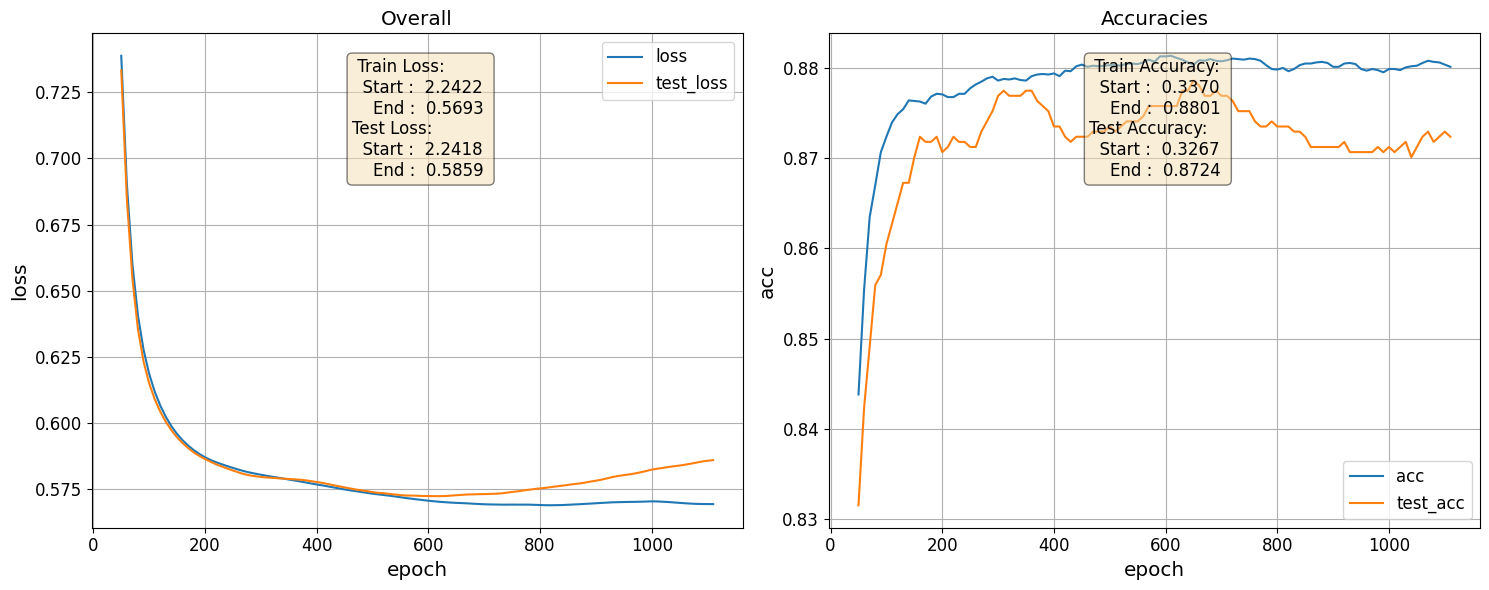

In [122]:
fig, axes = plt.subplots(1,2 , figsize = (15,6),)

l_range = 5 # ignoring first few records
x_var = 'epoch'
y1_var = 'loss'
y2_var = 'test_loss'

ax = axes[0]

loss_df[l_range:].plot(x = x_var, y = [y1_var, y2_var], ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel(x_var)
ax.set_ylabel(y1_var)
ax.set_title('Overall')
ax.grid();

ax = axes[1]

y1_var = 'acc'
y2_var = 'test_acc'

loss_df[l_range:].plot(x = x_var, y = [y1_var, y2_var], ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot# properties  matplotlib.patch.Patch 
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel(x_var)
ax.set_ylabel(y1_var)
ax.set_title('Accuracies'.format(l_range))
ax.grid();
plt.tight_layout()

In [123]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :{:.5f}'.format( accuracy_score(np.argmax(y_train, axis = 1), y_pred ) ) )

Accuracy score on Train Data :0.88019


In [124]:
print(classification_report(np.argmax(y_train, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1828
           1       0.91      0.93      0.92      5296
           2       0.83      0.86      0.84      6174
           3       0.85      0.78      0.81      3086

    accuracy                           0.88     16384
   macro avg       0.90      0.89      0.89     16384
weighted avg       0.88      0.88      0.88     16384



In [125]:
y_pred = predict(model, X_test)

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(np.argmax(y_test, axis = 1), y_pred)))

Accuracy score on Test Data :0.87238


In [126]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       197
           1       0.91      0.92      0.92       570
           2       0.81      0.86      0.83       664
           3       0.84      0.74      0.79       332

    accuracy                           0.87      1763
   macro avg       0.89      0.88      0.89      1763
weighted avg       0.87      0.87      0.87      1763



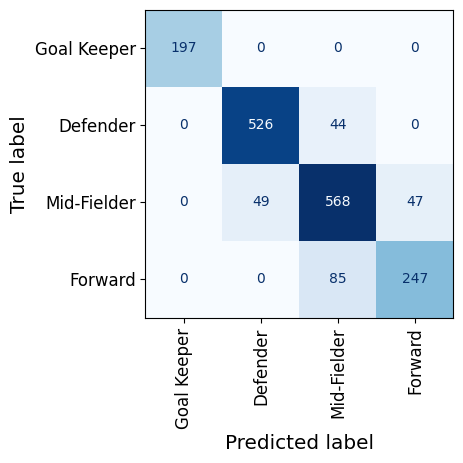

In [127]:
cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

In [128]:
loss_df[loss_df['test_loss'] == loss_df['test_loss'].min()]

,epoch,loss,test_loss,acc,test_acc
61,610,0.570329,0.572277,0.881348,0.87578
